Memory Usage: 5.7%
Found 19787 Real images in directory: /kaggle/input/deepfake-and-real-images/Dataset/Validation/Real
Found 19641 Fake images in directory: /kaggle/input/deepfake-and-real-images/Dataset/Validation/Fake


<ipython-input-1-44eaf9a40823>:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(final_model_path, map_location=device))


Model loaded successfully from: /kaggle/input/deepfake/other/default/1/best_model_fold5.pth
Sample Predictions on validation dataset:


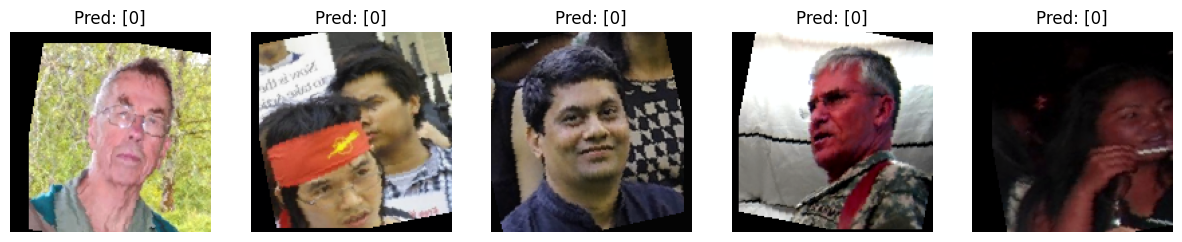

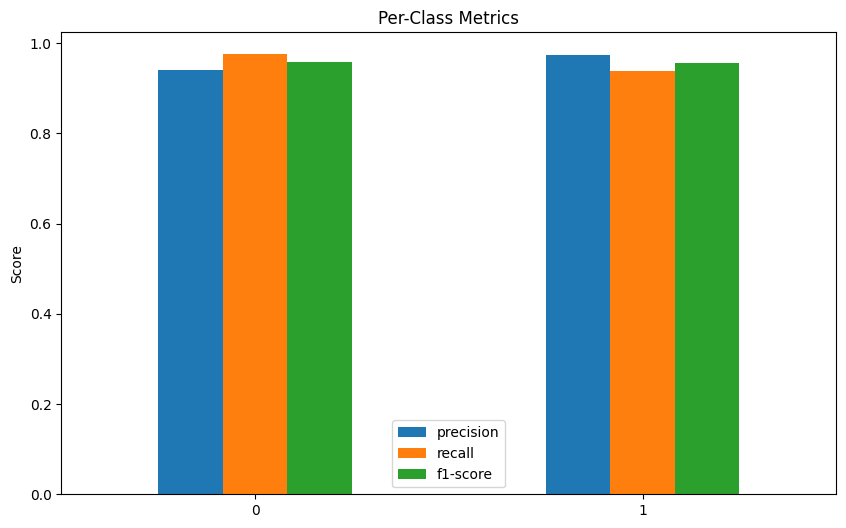

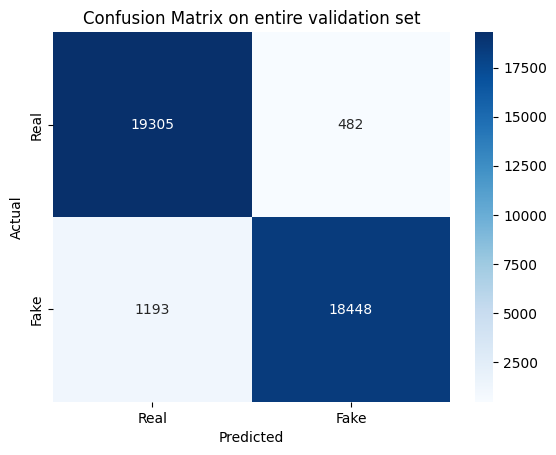


Overall Results on validation set:
Accuracy: 0.9575
Weighted Precision: 0.9581
Weighted Recall: 0.9575
Weighted F1-score: 0.9575
Memory Usage: 6.7%


In [1]:
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import gc
import psutil
from IPython.display import clear_output


def clear_memory():
    """Clears memory to prevent out-of-memory errors"""
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Memory Usage: {psutil.virtual_memory().percent}%")
    
clear_memory()

# Step 1: Dataset and DataLoader
class ImageDataset(Dataset):
    def __init__(self, image_dir, label, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        for file_name in os.listdir(image_dir):
            file_path = os.path.join(image_dir, file_name)
            if file_name.endswith(('.jpg', '.png', '.jpeg')):
                self.image_paths.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations - more robust
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet Normalization
])

# Step 3: Paths to Test/Real and Test/Fake
test_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Validation"  # Use same as training for validation
real_dir = os.path.join(test_dir, "Real")
fake_dir = os.path.join(test_dir, "Fake")

# Verify the existence of directories
if not os.path.exists(real_dir):
    raise FileNotFoundError(f"Real directory not found: {real_dir}")
if not os.path.exists(fake_dir):
    raise FileNotFoundError(f"Fake directory not found: {fake_dir}")

# Count the number of images in each directory
num_real_images = len([f for f in os.listdir(real_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
num_fake_images = len([f for f in os.listdir(fake_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

# Print information
print(f"Found {num_real_images} Real images in directory: {real_dir}")
print(f"Found {num_fake_images} Fake images in directory: {fake_dir}")

# Dataset
real_dataset = ImageDataset(real_dir, 0, transform)
fake_dataset = ImageDataset(fake_dir, 1, transform)

dataset = real_dataset + fake_dataset
labels = real_dataset.labels + fake_dataset.labels


# Step 4: CNN Model (Improved)
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        # Convolutional layers with batch norm and ReLU
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       

        # Calculate size dynamically based on output of convolutions
        test_tensor = torch.randn(1, 3, 150, 150)
        conv_output_size = self.get_conv_output_size(test_tensor)

        # Fully connected layers with ReLU
        self.fc1 = nn.Linear(conv_output_size, 512) #remove batchnorm
        self.fc2 = nn.Linear(512, 128) #remove batchnorm
        self.fc3 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)

    def get_conv_output_size(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)
        return x.size(1)

    def forward(self, x):
        # Convolutional layers with Batch Norm and ReLU
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)  # flatten
        # Fully connected layers with  ReLU
        x = torch.relu(self.fc1(x)) #remove batchnorm
        x = self.dropout(x)
        x = torch.relu(self.fc2(x)) #remove batchnorm
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model (change the path to your saved final model)
final_model_path = "/kaggle/input/deepfake/other/default/1/best_model_fold5.pth" # Make sure it's the right path!
model = ImprovedCNN().to(device)

try:
  model.load_state_dict(torch.load(final_model_path, map_location=device))
  print(f"Model loaded successfully from: {final_model_path}")
except FileNotFoundError:
    print(f"Error: Model file not found at {final_model_path}")
    exit()
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

model.eval()

# Create DataLoader for the entire dataset
all_data_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)

# Make predictions on the entire validation set
preds, actuals = [], []
sample_images = []
sample_predictions = []
with torch.no_grad():
    for images, labels in all_data_loader:
        images = images.to(device)
        outputs = model(images)
        preds.extend((outputs > 0.5).long().cpu().numpy())
        actuals.extend(labels.numpy())
        if len(sample_images) < 5:
            sample_images.extend(images.cpu().numpy())
            sample_predictions.extend((outputs > 0.5).long().cpu().numpy())

# Display Sample Predictions
print("Sample Predictions on validation dataset:")
plt.figure(figsize=(15, 5))
for i, (image, pred) in enumerate(zip(sample_images,sample_predictions)):
    if i >= 5:
      break
    image = np.transpose(image, (1, 2, 0))
    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    image = np.clip(image, 0, 1)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Pred: {pred}")
    plt.axis("off")
plt.show()
    
# Generate classification report and confusion matrix
report = classification_report(actuals, preds, output_dict=True, zero_division=0)
confusion = confusion_matrix(actuals, preds)

# Display per-class metrics
class_names = ['0', '1']
metrics_df = pd.DataFrame(report).transpose()
metrics_df = metrics_df[metrics_df.index.isin(class_names)]


if not metrics_df.empty:
    metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
    plt.title('Per-Class Metrics')
    plt.xticks(rotation=0)
    plt.ylabel('Score')
    plt.show()
else:
        print("No per-class metrics to plot. Likely one class was missing.")

# Display confusion matrix
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix on entire validation set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Print the overall results
print(f"\nOverall Results on validation set:")
print(f"Accuracy: {report['accuracy']:.4f}")
print(f"Weighted Precision: {report['weighted avg']['precision']:.4f}")
print(f"Weighted Recall: {report['weighted avg']['recall']:.4f}")
print(f"Weighted F1-score: {report['weighted avg']['f1-score']:.4f}")

clear_memory()